<a href="https://colab.research.google.com/github/nogukou0124/sts/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ドライブと接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ファイルの読み込み
class File:
  def input_file(self,filepath):
      data = []
      with open(filepath, 'r', encoding='utf-8') as file:
          for line in file.read().splitlines():
            double_sentences = line.split('\t')
            data.append(double_sentences[0])
            data.append(double_sentences[1])
      return data

  
  def gs_file(self):
      data = []
      gs_path = []
      gs_path.append("./drive/MyDrive/sts/learn/STS.gs.OnWN.txt")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.MSRvid.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.headlines.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.MSRpar.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.SMTeuroparl.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.deft-forum.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.deft-news.txt ")
      gs_path.append("/content/drive/MyDrive/sts/add/STS.gs.tweet-news.txt ")
      for gs in gs_path:
        with open(gs, 'r', encoding='utf-8') as file:
            for line in file.read().splitlines():
              data.append(float(line) / 5)
      return data

          
  def pre_learn_data(self):
      learns = []
      learn_data = []
      learn_data.append("./drive/MyDrive/sts/learn/STS.input.OnWN.txt")
      learn_data.append("./drive/MyDrive/sts/add/STS.input.MSRvid.txt")
      learn_data.append("./drive/MyDrive/sts/add/STS.input.headlines.txt")
      learn_data.append("/content/drive/MyDrive/sts/add/STS.input.MSRpar.txt")
      learn_data.append("/content/drive/MyDrive/sts/add/STS.input.SMTeuroparl.txt")
      learn_data.append("/content/drive/MyDrive/sts/add/STS.input.deft-forum.txt")
      learn_data.append("/content/drive/MyDrive/sts/add/STS.input.deft-news.txt")
      learn_data.append("/content/drive/MyDrive/sts/add/STS.input.tweet-news.txt")
      for learn in learn_data:
          for input in self.input_file(learn):
              learns.append(input)
      return learns

  def pre_test_data(self):
      test_path = "./drive/MyDrive/sts/test/STS.input.images.txt"
      return self.input_file(test_path)

  output_filepath = "./drive/MyDrive/sts/test/STS.output.images.txt"
  def output_file(self,output_data):
      with open(self.output_filepath, 'w', encoding='utf-8') as file:
          for output in output_data:
            file.write(f'{output}\n')

In [ ]:
# データ分析
from matplotlib import pyplot as plt

class Analysis:
  def view_analysis(self):
      data_list = []
      with open("./drive/MyDrive/sts/test/STS.output.images.txt", 'r', encoding='utf-8') as file:
          for line in file.read().splitlines():
              data_list.append(line)

      correct_data = []
      with open("./drive/MyDrive/sts/test/STS.gs.images.txt", 'r', encoding='utf-8') as file:
          for line in file.read().splitlines():
              correct_data.append(line)
              
      docs = []
      with open("./drive/MyDrive/sts/test/STS.input.images.txt", 'r', encoding='utf-8') as file:
          for line in file.read().splitlines():
              docs.append(line)

      fig = plt.figure()

      x = []
      y = []
      constant_max = 30
      constant_min = 1

      for (data,correct) in zip(data_list,correct_data):
          x.append(float(data))
          y.append(float(correct))

      
      file_path = "./drive/MyDrive/sts/analysis/data.txt"
      with open(file_path, 'w', encoding='utf-8') as file:
          for (data,correct,doc) in zip(x,y,docs):
              file.write(f"[{data},{correct}] {doc}\n")

      plt.scatter(x,y)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 7.4 MB/s 
     |████████████████████████████████| 182 kB 93.8 MB/s 
     |████████████████████████████████| 7.6 MB 71.1 MB/s 


In [ ]:
from keras.layers.pooling.max_pooling1d import MaxPooling1D
import torch
import torch.nn as nn
from transformers import BertModel,BertGenerationTokenizer,BertTokenizer,BertConfig
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,SimpleRNN,GlobalAveragePooling1D,Concatenate

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

model_config = BertConfig.from_pretrained('bert-base-cased', output_hidden_states=True)
model = BertModel.from_pretrained('bert-base-cased',config=model_config)
# model = BertPreTrainedModel.from_pretrained('bert-base-cased')
model = model.cuda()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def calc_sim(text1,text2):
  # 文章の符号化
  encoding = tokenizer(text1, text2,  max_length=40, padding='max_length',truncation=True, return_tensors='pt')
  # encoding = tokenizer(tests[0],tests[1], max_length=32, padding='max_length',truncation=True)
  encoding = { k:v.cuda() for k, v in encoding.items() }

  # 事前学習
  with torch.no_grad():
    output = model(**encoding)
    last_hidden_state = output.last_hidden_state
  
  # last_hidden_state = last_hidden_state[:, 0, :]
  last_hidden_state = last_hidden_state.cpu()
  last_hidden_state = np.array(last_hidden_state)
  return last_hidden_state


In [ ]:
# 損失関数のグラフ表示
def view_loss(history):
  fig = plt.figure()
  plt.plot(history.history["loss"])
  # fig.savefig("./images/loss.jpg")

In [ ]:
# テストデータの作成
def create_data_x(data_x):
  data = []
  it = iter(data_x[0:len(data_x)])
  for t1,t2 in zip(it,it):
    data.append(calc_sim(t1,t2))
  data = np.array(data)
  data = data.squeeze()
  return data

In [ ]:
#データの呼び出し
file = File()
learns = file.pre_learn_data()
tests = file.pre_test_data()

train_x = create_data_x(learns)
print(train_x.shape)

train_y = file.gs_file()
train_y = np.array(train_y)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

(5234, 40, 768)


Epoch 1/50
164/164 [==============================] - 4s 17ms/step - loss: 0.4188
Epoch 2/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0419
Epoch 3/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0314
Epoch 4/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0255
Epoch 5/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0221
Epoch 6/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0190
Epoch 7/50
164/164 [==============================] - 3s 16ms/step - loss: 0.0164
Epoch 8/50
164/164 [==============================] - 3s 17ms/step - loss: 0.0135
Epoch 9/50
164/164 [==============================] - 3s 17ms/step - loss: 0.0117
Epoch 10/50
164/164 [==============================] - 3s 17ms/step - loss: 0.0093
Epoch 11/50
164/164 [==============================] - 3s 17ms/step - loss: 0.0078
Epoch 12/50
164/164 [==============================] - 3s 17ms/step - loss: 0.0068
Epoch 13/50
1

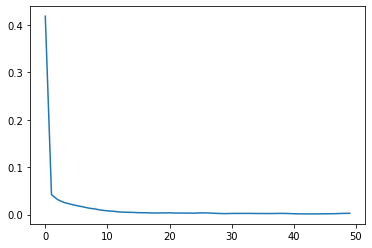

In [ ]:
# モデルの生成
fine_model = Sequential()
fine_model.add(LSTM(768,return_sequences=False,input_shape=(train_x.shape[1],train_x.shape[2])))
fine_model.add(Dense(1))
fine_model.compile(loss="mean_squared_error", optimizer="adam")

# 訓練
history = fine_model.fit(train_x, train_y, epochs=50)
fine_model.summary()
view_loss(history)

In [ ]:
test_x = create_data_x(tests)
predicts = fine_model.predict(test_x)
predicts = predicts.flatten()
print(predicts.shape)
predicts = predicts.tolist()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

24/24 [==============================] - 0s 7ms/step
(750,)


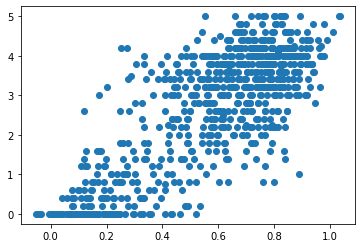

In [ ]:
# データの出力
file.output_file(predicts)

# データの分析
Analysis().view_analysis()

In [ ]:
# ピアソン相関
!perl ./drive/MyDrive/sts/correlation-noconfidence.pl  ./drive/MyDrive/sts/test/STS.gs.images.txt ./drive/MyDrive/sts/test/STS.output.images.txt 

Pearson: 0.78430


In [ ]:
# モデルの生成
model = Sequential()
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
# model.summary()